# Observation Plan 2025/07/09

## Imports

General imoprts

In [1]:
from zoneinfo import ZoneInfo

UTC = ZoneInfo('UTC')
EST = ZoneInfo('US/Eastern')

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.gridspec import GridSpec

date_formatter = dates.DateFormatter('%H:%M')

Astropy imports

In [3]:
import astropy.units as u
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import EarthLocation, SkyCoord

from astroplan import Observer, FixedTarget
from astroplan.plots import plot_airmass

Suppress common warnings for cleaner output

In [4]:
import warnings
warnings.filterwarnings('ignore', message='no explicit representation of timezones available for np.datetime64')
warnings.filterwarnings('ignore', message='.*TimeDelta.*')

OpenNGC catalog

In [5]:
import pyongc.ongc as ngc

Some functions

In [6]:
def make_chart(arp, hips='CDS/P/DSS2/color'):
    """
    Create a finder chart for the given Arp number.
    """
    survey = hips.split('/')
    filename = f'finder_charts/Arp_{arp}_{survey[2]}_{survey[3]}.fits'
    
    with fits.open(filename) as hdul:
        hdu = hdul[0]
        r, g, b = hdu.data[0:3]
        wcs = WCS(hdu.header)[0]
        fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=wcs))
        rgb_image = make_rgb(r, g, b)
        ax.imshow(rgb_image)
        ax.grid(alpha=.5)
        ax.set(xlabel='RA[hms]', ylabel='Dec[dms]')
        ax.set_title(f'Arp {arp} ({arpord.loc[arp]["Name"]})')
        # fig.tight_layout(pad=0.1)
        fig.savefig(f'{filename.split('.')[0]}.pdf')


## Observer location and time

An observer can be initialized with a site from the astropy sites list. `EarthLocation.get_site_names()` will return a list of default observatories. Sites not in the default list can be defined using `EarthLocation.from_geodetic()`.

### Bear Branch Observatory, Westminster, MD

In [7]:
loc_bb = EarthLocation.from_geodetic(-76.986530*u.deg, 39.647191*u.deg, 210*u.m)
bb = Observer(location=loc_bb, name="Bear Branch Observatory, Westminster, MD",
                       timezone="US/Eastern")

### Observation times

UTC Date and Time for obervations

In [8]:
time = Time('2025-07-09 16:00:00', location=loc_bb) # 2025-07-09 12:00:00 EDT

Sunset, Sunrise, and astronomical twilight.

In [9]:
sunset = bb.sun_set_time(time, which='next')
end_ast_twi = bb.twilight_evening_astronomical(time, which='next')
begin_ast_twi = bb.twilight_morning_astronomical(time, which='next')
sunrise = bb.sun_rise_time(time, which='next')

Set up the range for airmass plots. Returns `observe_time`, an array of UTC julian dates 1 h before sunset to 1 h after sunrise the following day.

In [10]:
start_time = sunset + 30*u.minute
start_time = Time(start_time.datetime.replace(minute=0, second=0, microsecond=0))-1*u.h
end_time = sunrise + 30*u.minute
end_time = Time(end_time.datetime.replace(minute=0, second=0, microsecond=0))+1*u.h

In [11]:
t_delta = end_time - start_time
observe_time = start_time + t_delta*np.linspace(0, 1, 75)

### Sun and Moon

In [12]:
local_sunset = sunset.to_datetime(timezone=UTC).astimezone(EST)
local_end_ast_twi = end_ast_twi.to_datetime(timezone=UTC).astimezone(EST)
local_begin_ast_twi = begin_ast_twi.to_datetime(timezone=UTC).astimezone(EST)
local_sunrise = sunrise.to_datetime(timezone=UTC).astimezone(EST)

print(f"Sunset: {local_sunset.strftime('%b %-d %H:%M %Z'):>23}")
print(f"End Ast Twi: {local_end_ast_twi.strftime('%b %-d %H:%M %Z'):>18}")
print(f"Begin Ast Twi: {local_begin_ast_twi.strftime('%b %-d %H:%M %Z'):>16}")
print(f"Sunrise: {local_sunrise.strftime('%b %-d %H:%M %Z'):>22}")

Sunset:         Jul 9 20:32 EDT
End Ast Twi:    Jul 9 22:35 EDT
Begin Ast Twi: Jul 10 03:51 EDT
Sunrise:       Jul 10 05:54 EDT


In [13]:
moonrise = bb.moon_rise_time(time, horizon=-50*u.arcmin, which='nearest').to_datetime(timezone=UTC)
moonset = bb.moon_set_time(time, horizon=-50*u.arcmin, which='nearest').to_datetime(timezone=UTC)
illum = bb.moon_illumination(end_ast_twi)

print(f"Moonrise: {moonrise.astimezone(EST).strftime('%b %-d %H:%M %Z'):>16}")
print(f"Moonset: {moonset.astimezone(EST).strftime('%b %-d %H:%M %Z'):>17}")
print(f"Illumination: {illum:>3.1%}")

Moonrise:  Jul 9 20:16 EDT
Moonset:   Jul 9 04:08 EDT
Illumination: 99.2%


Zenith coordinates at astronomical twilight

In [14]:
Z = SkyCoord(alt=90*u.deg, az=0*u.deg, obstime=end_ast_twi, location=loc_bb, frame='altaz').icrs
print(f'Zenith: {Z.ra.to_string(unit=u.hourangle, precision=1):>10}, {Z.dec.to_string(precision=1)}')

Zenith: 16h39m43.7s, 39d41m43.8s


## Targets

In [15]:
target_list = Table.read('arp_targets.csv', format='csv')
target_list.add_index('Arp')

In [16]:
sb = [ngc.Dso(id).surface_brightness for id in target_list['Name']]
target_list.add_column(sb, index=3,name='SurBr')

target_list.remove_column('u_VT')

In [17]:
target_list

Arp,Name,VT,SurBr,dim1,dim2,u_dim2,MType,Uchart,RAJ2000,DEJ2000,Const
int64,str8,float64,float64,float64,float64,int64,str13,int64,str10,str9,str14
13,NGC 7448,11.6,21.66,2.7,1.2,--,SA(rs)bc,213,23 00 02.4,+15 59 22,Pegasus
25,NGC 2276,11.4,22.26,2.8,2.7,--,SAB(rs)c,1,07 27 13.0,+85 45 20,Cepheus
26,M 101,7.9,23.97,28.9,27.0,--,SAB(rs)cd I,49,14 03 12.7,+54 21 02,Ursa Major
28,NGC 7678,11.8,22.49,2.4,1.7,--,SAB(rs)c I-II,169,23 28 27.8,+22 25 16,Pegasus
29,NGC 6946,8.8,23.73,11.6,9.9,--,SAB(rs)cd,32,20 34 52.2,+60 09 14,Cepheus
38,NGC 6412,11.7,22.63,2.5,2.2,--,SAS5,12,17 29 36.2,+75 42 17,Draco
84,NGC 5395,11.4,22.45,2.9,1.6,--,SA(s)b pec,110,13 58 38.3,+37 25 32,Canes Venatici
85,M 51,8.4,22.9,11.4,7.0,--,SA(s)bc pec,76,13 29 52.3,+47 11 54,Canes Venatici
86,NGC 7753,12.0,22.64,3.3,2.1,--,SAB(rs)bc I,89,23 47 04.7,+29 29 01,Pegasus


In [18]:
targets = [FixedTarget(SkyCoord(ra=t['RAJ2000'], dec=t['DEJ2000'], frame='icrs',
             unit=(u.hourangle, u.deg)), name=f'Arp {t['Arp']} ({t['Name']})') for t in target_list]

## Airmass plots

In [19]:
moon = bb.moon_altaz(observe_time).alt
masked_moon = np.ma.array(moon, mask=moon < 0)
illum = bb.moon_illumination(end_ast_twi)

Arp 29 (NGC 6946)

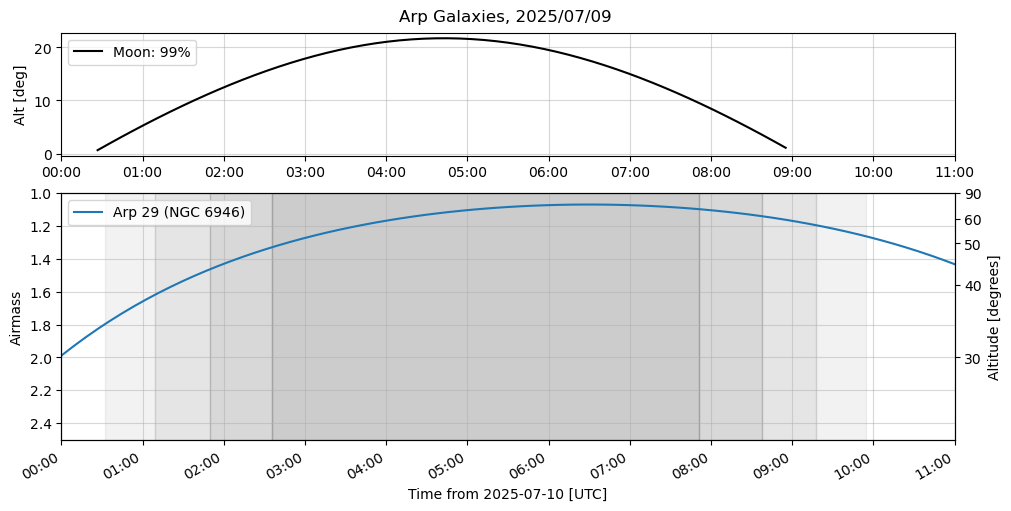

In [20]:
fig = plt.figure(figsize=(10,5), constrained_layout=True)
fig.suptitle('Arp Galaxies, 2025/07/09')
gs = GridSpec(3, 1, figure=fig)

ax2 = fig.add_subplot(gs[1:,0])
ax1 = fig.add_subplot(gs[0,0], sharex=ax2)
ax1.grid(True, alpha=.5)
ax1.set_ylabel('Alt [deg]')
ax1.plot(observe_time.plot_date, masked_moon, '-k', label=f'Moon: {illum:2.0%}')
ax1.legend(loc='upper left')

ax2.grid(True, alpha=.5)
plot_airmass(targets[4], bb, observe_time, altitude_yaxis=True, brightness_shading=True, max_airmass=2.5, ax=ax2)
ax2.legend(loc='upper left')

plt.savefig('./plots/arp_2025-07-09_29.pdf')

In [21]:
print(ngc.printDetails(ngc.Dso(target_list.loc[29]['Name'])))

+-----------------------------------------------------------------------------+
| Id: 13013     Name: NGC6946           Type: Galaxy                          |
| R.A.: 20:34:52.32      Dec.: +60:09:14.1      Constellation: Cyg            |
| Common names:                                                               |
|    Fireworks Galaxy                                                         |
+-----------------------------------------------------------------------------+
| Major axis: 11.4'      Minor axis: 10.84'     Position angle: 52°           |
| B-mag: 9.76    V-mag: 9.05    J-mag: 6.27    H-mag: 5.91    K-mag: 5.37     |
|                                                                             |
| Parallax: N/A          Radial velocity: 45km/s        Redshift: 0.000150    |
|                                                                             |
| Proper apparent motion in RA: N/A                                           |
| Proper apparent motion in Dec: N/A    

Arp 85 (NGC 5194)

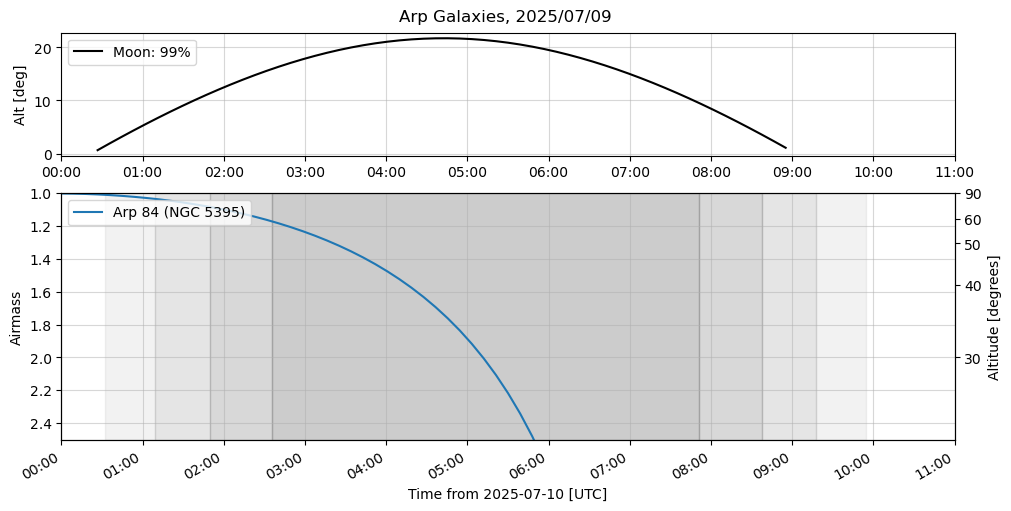

In [22]:
fig = plt.figure(figsize=(10,5), constrained_layout=True)
fig.suptitle('Arp Galaxies, 2025/07/09')
gs = GridSpec(3, 1, figure=fig)

ax2 = fig.add_subplot(gs[1:,0])
ax1 = fig.add_subplot(gs[0,0], sharex=ax2)
ax1.grid(True, alpha=.5)
ax1.set_ylabel('Alt [deg]')
ax1.plot(observe_time.plot_date, masked_moon, '-k', label=f'Moon: {illum:2.0%}')
ax1.legend(loc='upper left')

ax2.grid(True, alpha=.5)
plot_airmass(targets[6], bb, observe_time, altitude_yaxis=True, brightness_shading=True, max_airmass=2.5, ax=ax2)
ax2.legend(loc='upper left')

plt.savefig('./plots/arp_2025-07-09_85.pdf')

In [23]:
print(ngc.printDetails(ngc.Dso(target_list.loc[85]['Name'])))

+-----------------------------------------------------------------------------+
| Id: 11138     Name: NGC5194           Type: Galaxy                          |
| R.A.: 13:29:52.71      Dec.: +47:11:42.6      Constellation: CVn            |
| Also known as:                                                              |
|    M051                                                                     |
| Common names:                                                               |
|    Whirlpool Galaxy                                                         |
+-----------------------------------------------------------------------------+
| Major axis: 13.71'     Minor axis: 11.67'     Position angle: 163°          |
| B-mag: 8.61    V-mag: 8.36    J-mag: 6.4     H-mag: 5.65    K-mag: 5.5      |
|                                                                             |
| Parallax: 7.8mas       Radial velocity: 465km/s       Redshift: 0.001550    |
|                                       